In [1]:
# Importing the relevant libraries
import os
from pathlib import Path
import joblib
import gc

# Libraries for Data Manipulation
import numpy as np
import pandas as pd

# Libraries for Data Visualization
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy import stats
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": "#FFFAF0", "figure.facecolor": "#FFFAF0"})
sns.set_context("poster", font_scale=0.7)

# Libraries to Handle Warnings
import warnings
warnings.filterwarnings('ignore')

# Setting Display Options
pd.set_option("display.max.columns", None)

# Libraries for Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 1) loading Dataset

In [2]:
BASE_DIR = Path("E:/ZeusOps/data/CIC-IDS-2017/raw")

# List to store DataFrames
dfs = []

# Load all CSVs in the folder
for csv_file in BASE_DIR.glob("*.csv"):
  dfs.append(pd.read_csv(csv_file))

# Concatenate into a single DataFrame
data = pd.concat(dfs, axis=0, ignore_index=True)

# Optional: delete the list to free memory
del dfs


In [3]:
# Display the first few rows
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
# Get dataset dimensions
print(f"Dataset Dimensions: {data.shape}")

Dataset Dimensions: (2830743, 79)


In [5]:
# Display 10 random rows
data.sample(n=10, random_state=42)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
746827,50545,232,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,8620.689655,2.320000e+02,0.000000e+00,232,232,0,0.000000e+00,0.000000e+00,0,0,0,0.00000,0.00000,0,0,0,0,0,0,32,32,4310.344828,4310.344828,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,1,0.000000,0.000000,0.000000,32,0,0,0,0,0,0,1,0,1,0,357,32832,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
946912,53,31226,2,2,68,380,34,34,34.000000,0.000000,190,190,190.000000,0.000000,1.434702e+04,128.098380,1.040867e+04,1.802228e+04,31219,3,3,3.000000e+00,0.000000e+00,3,3,4,4.00000,0.00000,4,4,0,0,0,0,64,40,64.049190,64.049190,34,190,96.400000,85.444719,7.300800e+03,0,0,0,0,0,0,0,0,1,120.500000,34.000000,190.000000,64,0,0,0,0,0,0,2,68,2,380,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2216843,80,99951883,9,7,317,11595,317,0,35.222222,105.666667,5792,0,1656.428571,2118.227235,1.191773e+02,0.160077,6.663459e+06,2.580000e+07,99900000,1,99900000,1.250000e+07,3.530000e+07,99900000,1,56541,9423.50000,18378.17710,46050,14,0,0,0,0,296,232,0.090043,0.070034,0,5792,700.705882,1538.694445,2.367581e+06,0,0,0,0,1,0,0,0,0,744.500000,35.222222,1656.428571,296,0,0,0,0,0,0,9,317,7,11595,274,235,1,32,999.0,0.0,999,999,99900000.0,0.0,99900000,99900000,DoS Hulk
699389,53,30894,4,2,140,172,35,35,35.000000,0.000000,86,86,86.000000,0.000000,1.009905e+04,194.212468,6.178800e+03,8.507391e+03,17161,1,17211,5.737000e+03,9.893503e+03,17161,1,49,49.00000,0.00000,49,49,0,0,0,0,128,64,129.474979,64.737489,35,86,49.571429,24.885452,6.192857e+02,0,0,0,0,0,0,0,0,0,57.833333,35.000000,86.000000,128,0,0,0,0,0,0,4,140,2,172,-1,-1,3,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1170268,53,48943,2,2,88,166,44,44,44.000000,0.000000,83,83,83.000000,0.000000,5.189710e+03,81.727724,1.631433e+04,2.825206e+04,48937,3,3,3.000000e+00,0.000000e+00,3,3,3,3.00000,0.00000,3,3,0,0,0,0,40,64,40.863862,40.863862,44,83,59.600000,21.361180,4.563000e+02,0,0,0,0,0,0,0,0,1,74.500000,44.000000,83.000000,40,0,0,0,0,0,0,2,88,2,166,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
800686,53,23728,1,1,56,84,56,56,56.000000,0.000000,84,84,84.000000,0.000000,5.900202e+03,84.288604,2.372800e+04,0.000000e+00,23728,23728,0,0.000000e+00,0.000000e+00,0,0,0,0.00000,0.00000,0,0,0,0,0,0,32,32,42.144302,42.144302,56,84,65.333333,16.165808,2.613333e+02,0,0,0,0,0,0,0,0,1,98.000000,56.000000,84.000000,32,0,0,0,0,0,0,1,56,1,84,-1,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1434488,23,3,2,0,4,0,2,2,2.000000,0.000000,0,0,0.000000,0.000000,1.333333e+06,666666.666700,3.000000e+00,0.000000e+00,3,3,3,3.000000e+00,0.000000e+00,3,3,0,0.00000,0.00000,0,0,0,0,0,0,48,0,666666.666700,0.000000,2,2,2.000000,0.000000,0.000000e+00,0,0,0,1,0,0,0,0,0,3.000000,2.000000,0.000000,48,0,0,0,0,0,0,2,4,0,0,102

In [6]:
# Display data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

# 2) Data Cleaning

In [7]:
# Checking for missing values
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100

# Printing columns with missing values
for column, count in missing_values.items():
  if count != 0:
    print(f"Column '{column}' has {count} missing values, which is {missing_percentage[column]:.2f}% of the total")

Column 'Flow Bytes/s' has 1358 missing values, which is 0.05% of the total


In [8]:
# Removal of leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

2.1. Duplicates and Infinite

In [9]:
# Checking and counting duplicates
duplicates = data.duplicated()
duplicate_count = duplicates.sum()

# Output results
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 308381


In [10]:
# Removal of duplicates
data = data.drop_duplicates(keep='first')
del duplicates
data.shape

(2522362, 79)

In [11]:
# Identify columns with identical data
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
  for col2 in columns:
    if col1 != col2:
      if data[col1].equals(data[col2]):
        if (col1 not in identical_columns) and (col1 in list_control):
          identical_columns[col1] = [col2]
          list_control.remove(col2)
        elif (col1 in identical_columns) and (col1 in list_control):
          identical_columns[col1].append(col2)
          list_control.remove(col2)

# Print the result
if identical_columns:
  print("Identical columns found:")
  for key, value in identical_columns.items():
    print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


In [12]:
# Removing the columns with duplicated values
for key, value in identical_columns.items():
  data.drop(columns=value, inplace=True)

In [13]:
data.reset_index(drop=True, inplace=True)
print(data.columns)
data.shape

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
       'PSH Flag C

(2522362, 67)

In [14]:
# Checking for infinite values
num_columns = data.select_dtypes(include = np.number).columns
has_infinite = np.isinf(data[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [15]:
# Treating infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

2.2. Missing Values

In [16]:
# Attack counts
attack_counts = data['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = data.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2096484,2095057,1427,0.07
1,DoS Hulk,172849,172846,3,0.00
2,DDoS,128016,128014,2,0.00
3,PortScan,90819,90694,125,0.14
4,DoS GoldenEye,10286,10286,0,0.00
5,FTP-Patator,5933,5931,2,0.03
6,DoS slowloris,5385,5385,0,0.00
7,DoS Slowhttptest,5228,5228,0,0.00
8,SSH-Patator,3219,3219,0,0.00
9,Bot,1953,1948,5,0.26


In [17]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
  print(f'The following columns have over {threshold}% of missing values:')
  print(high_missing_cols)
else:
  print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [18]:
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = data.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total rows with missing values: 1564


In [19]:
# Dropping missing values
data = data.dropna()
print(f'Dataset shape after row-wise removal: {data.shape}')

Dataset shape after row-wise removal: (2520798, 67)


2.3. Data-Driven Feature Selection

In [20]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in data.columns:
  if len(data[col].unique()) == 1:
    only_unique_cols.append(col)
    print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


In [21]:
# Dropping the columns with only one unique value
data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [22]:
# Checking the new shape after cleaning
data.shape

(2520798, 66)

2.3. Grouping/ Removing Attack Types

In [23]:
# Mapping the attacks to the new group
group_mapping = {
  'BENIGN': 'Normal Traffic',
  'DoS Hulk': 'DoS',
  'DDoS': 'DDoS',
  'PortScan': 'Port Scanning',
  'DoS GoldenEye': 'DoS',
  'FTP-Patator': 'Brute Force',
  'DoS slowloris': 'DoS',
  'DoS Slowhttptest': 'DoS',
  'SSH-Patator': 'Brute Force',
  'Bot': 'Bots',
  'Web Attack � Brute Force': 'Web Attacks',
  'Web Attack � XSS': 'Web Attacks',
  'Infiltration': 'Infiltration',
  'Web Attack � Sql Injection': 'Web Attacks',
  'Heartbleed': 'Miscellaneous'
}

# Map to new group column
data['Attack Type'] = data['Label'].map(group_mapping)

In [24]:
# Checking the new values
data['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64

In [25]:
# Dropping the old 'Label' column
data.drop(columns='Label', inplace=True)

2.3.2. Removal of Attack Types

In [26]:
# Removing rows with statistically irrelevant attack types
data.drop(data[(data['Attack Type'] == 'Infiltration') | (data['Attack Type'] == 'Miscellaneous')].index, inplace=True)

In [27]:
# Data shape and attack counts after removal
print(data.shape)
data['Attack Type'].value_counts()

(2520751, 66)


Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

# 3) Exploratory Data Analysis (EDA)

3.1. Descriptive Statistics

In [28]:
data.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
1753780,53,182790,1,1,42,105,42,42,42.000000,0.000000,105,105,105.000000,0.000000,8.042015e+02,10.941518,1.827900e+05,0.000000e+00,182790,182790,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,32,32,5.470759,5.470759,42,105,63.000000,36.373067,1.323000e+03,0,0,0,0,0,0,1,94.500000,42.000000,105.000000,42,105,-1,-1,0,32,0.00000,0.0000,0,0,0.0,0.000000,0,0,Normal Traffic
76975,80,49175,3,6,26,11607,20,0,8.666667,10.263203,5840,0,1934.500000,2538.919278,2.365633e+05,183.019827,6.146875e+03,1.692834e+04,48041,28,628,3.140000e+02,4.044651e+02,600,28,49029,9.805800e+03,2.137573e+04,48041,48,0,0,72,132,61.006609,122.013218,0,5840,1163.300000,2138.329153,4.572452e+06,0,0,1,0,0,0,2,1292.555556,8.666667,1934.500000,26,11607,8192,229,2,20,0.00000,0.0000,0,0,0.0,0.000000,0,0,DDoS
1217852,443,63557,6,4,121,3110,121,0,20.166667,49.398043,1338,0,777.500000,671.023845,5.083626e+04,157.339081,7.061889e+03,1.226510e+04,28687,1,63557,1.271140e+04,1.482385e+04,28860,1,29333,9.777667e+03,1.671390e+04,29077,48,0,0,204,136,94.403449,62.935633,0,1338,293.727273,532.395735,2.834452e+05,0,0,1,0,0,0,0,323.100000,20.166667,777.500000,121,3110,65535,4050,1,32,0.00000,0.0000,0,0,0.0,0.000000,0,0,Normal Traffic
400537,80,77762,3,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,38.579255,3.888100e+04,2.817113e+03,40873,36889,77762,3.888100e+04,2.817113e+03,40873,36889,0,0.000000e+00,0.000000e+00,0,0,0,0,96,0,38.579255,0.000000,0,0,0.000000,0.000000,0.000000e+00,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0,0,274,-1,0,32,0.00000,0.0000,0,0,0.0,0.000000,0,0,Normal Traffic
853815,53,31052,1,1,54,98,54,54,54.000000,0.000000,98,98,98.000000,0.000000,4.895015e+03,64.408090,3.105200e+04,0.000000e+00,31052,31052,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,32,20,32.204045,32.204045,54,98,68.666667,25.403412,6.453333e+02,0,0,0,0,0,0,1,103.000000,54.000000,98.000000,54,98,-1,-1,0,32,0.00000,0.0000,0,0,0.0,0.000000,0,0,Normal Traffic
2423908,80,42165340,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.047432,4.220000e+07,0.000000e+00,42200000,42200000,42200000,4.220000e+07,0.000000e+00,42200000,42200000,0,0.000000e+00,0.000000e+00,0,0,0,0,64,0,0.047432,0.000000,0,0,0.000000,0.000000,0.000000e+00,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,0,0,410,-1,0,32,0.00000,0.0000,0,0,42200000.0,0.000000,42200000,42200000,DoS
1020743,53,238,2,2,94,196,47,47,47.000000,0.000000,98,98,98.000000,0.000000,1.218487e+06,16806.722689,7.933333e+01,9.568873e+01,187,4,187,1.870000e+02,0.000000e+00,187,187,47,4.700000e+01,0.000000e+00,47,47,0,0,64,64,8403.361345,8403.361345,47,98,67.400000,27.933850,7.803000e+02,0,0,0,0,0,0,1,84.250000,47.000000,98.000000,94,196,-1,-1,1,32,0.00000,0.0000,0,0,0.0,0.000000,0,0,Normal Traffic
1458932,443,115869185,49,45,974,43793,517,0,19.877551,87.960605,2836,0,973.177778,721.901570,3.863581e+02,0.811260,1.245905e+06,3.267478e+06,10

In [29]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06
mean,8.690744e+03,1.659032e+07,1.025880e+01,1.155289e+01,6.065243e+02,1.811292e+04,2.311993e+02,1.920377e+01,6.350189e+01,7.732029e+01,9.749253e+02,4.316019e+01,3.406120e+02,3.765417e+02,1.410733e+06,4.729272e+04,1.446140e+06,3.278119e+06,1.029913e+07,1.704244e+05,1.625059e+07,2.919260e+06,3.668614e+06,1.014262e+07,1.135668e+06,1.110889e+07,2.027740e+06,1.668604e+06,5.260201e+06,1.086131e+06,4.866129e-02,3.173657e-05,-2.920137e+04,-2.555786e+03,4.086041e+04,6.513635e+03,1.683224e+01,1.063691e+03,1.906489e+02,3.301924e+02,5.457587e+05,3.209599e-02,2.721411e-04,2.976113e-01,3.118622e-01,1.013944e-01,2.733312e-04,7.004516e-01,2.124303e+02,6.350189e+01,3.406120e+02,6.065125e+02,1.811253e+04,7.265707e+03,2.228741e+03,5.997266e+00,-3.082291e+03,9.152230e+04,4.616835e+04,1.719410e+05,6.542438e+04,9.337159e+06,5.656738e+05,9.763454e+06,8.892545e+06
std,1.901294e+04,3.523140e+07,7.943824e+02,1.056905e+03,1.011595e+04,2.398149e+06,7.563122e+02,6.079887e+01,1.955512e+02,2.968824e+02,2.038152e+03,7.088017e+01,6.325259e+02,8.810516e+02,2.657109e+07,2.026384e+05,4.683206e+06,8.456766e+06,2.568515e+07,3.014332e+06,3.516506e+07,1.001642e+07,1.014211e+07,2.576630e+07,9.059514e+06,3.022732e+07,9.393467e+06,6.630262e+06,1.810112e+07,8.797295e+06,2.151590e-01,5.633434e-03,2.230983e+07,1.538914e+06,1.932673e+05,3.814495e+04,2.558433e+01,2.121512e+03,3.183446e+02,6.608798e+02,1.736455e+06,1.762551e-01,1.649446e-02,4.572077e-01,4.632540e-01,3.018503e-01,1.653048e-02,6.956626e-01,3.454933e+02,1.955512e+02,6.325259e+02,1.010095e+04,2.398116e+06,1.459805e+04,8.924482e+03,6.743909e+02,1.149769e+06,6.858746e+05,4.161453e+05,1.084664e+06,6.106447e+05,2.484810e+07,4.873871e+06,2.561725e+07,2.458139e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.610000e+08,-2.000000e+06,-1.300000e+01,0.000000e+00,-1.300000e+01,-1.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0

3.2. Correlation Analysis

In [30]:
# 1. Get numerical and categorical features (df, target_col='Attack Type') -> numerical features; categorical features
def get_feature_types(df, target_col='Attack Type'):
  numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
  categorical_features = df.select_dtypes(include=['object']).columns.tolist()

  # Remove target column if present
  if target_col in numeric_features:
    numeric_features.remove(target_col)
  if target_col in categorical_features:
    categorical_features.remove(target_col)

  return numeric_features, categorical_features

In [31]:
# 2. Correlation analysis (df, numeric_features) -> list of tuples with highly correlaed features
def correlation_analysis(df, numeric_features, threshold=0.85):
  # Calculate correlation matrix
  corr_matrix = df[numeric_features].corr()

  # Plot correlation heatmap
  plt.figure(figsize=(20, 20))
  sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth = 0.5)
  plt.title('Feature Correlation Heatmap')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  plt.show()

  # Identify highly correlated features
  threshold = threshold
  high_corr = np.where(np.abs(corr_matrix) > threshold)
  high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) for x, y in zip(*high_corr) if x != y and x < y]
  return high_corr

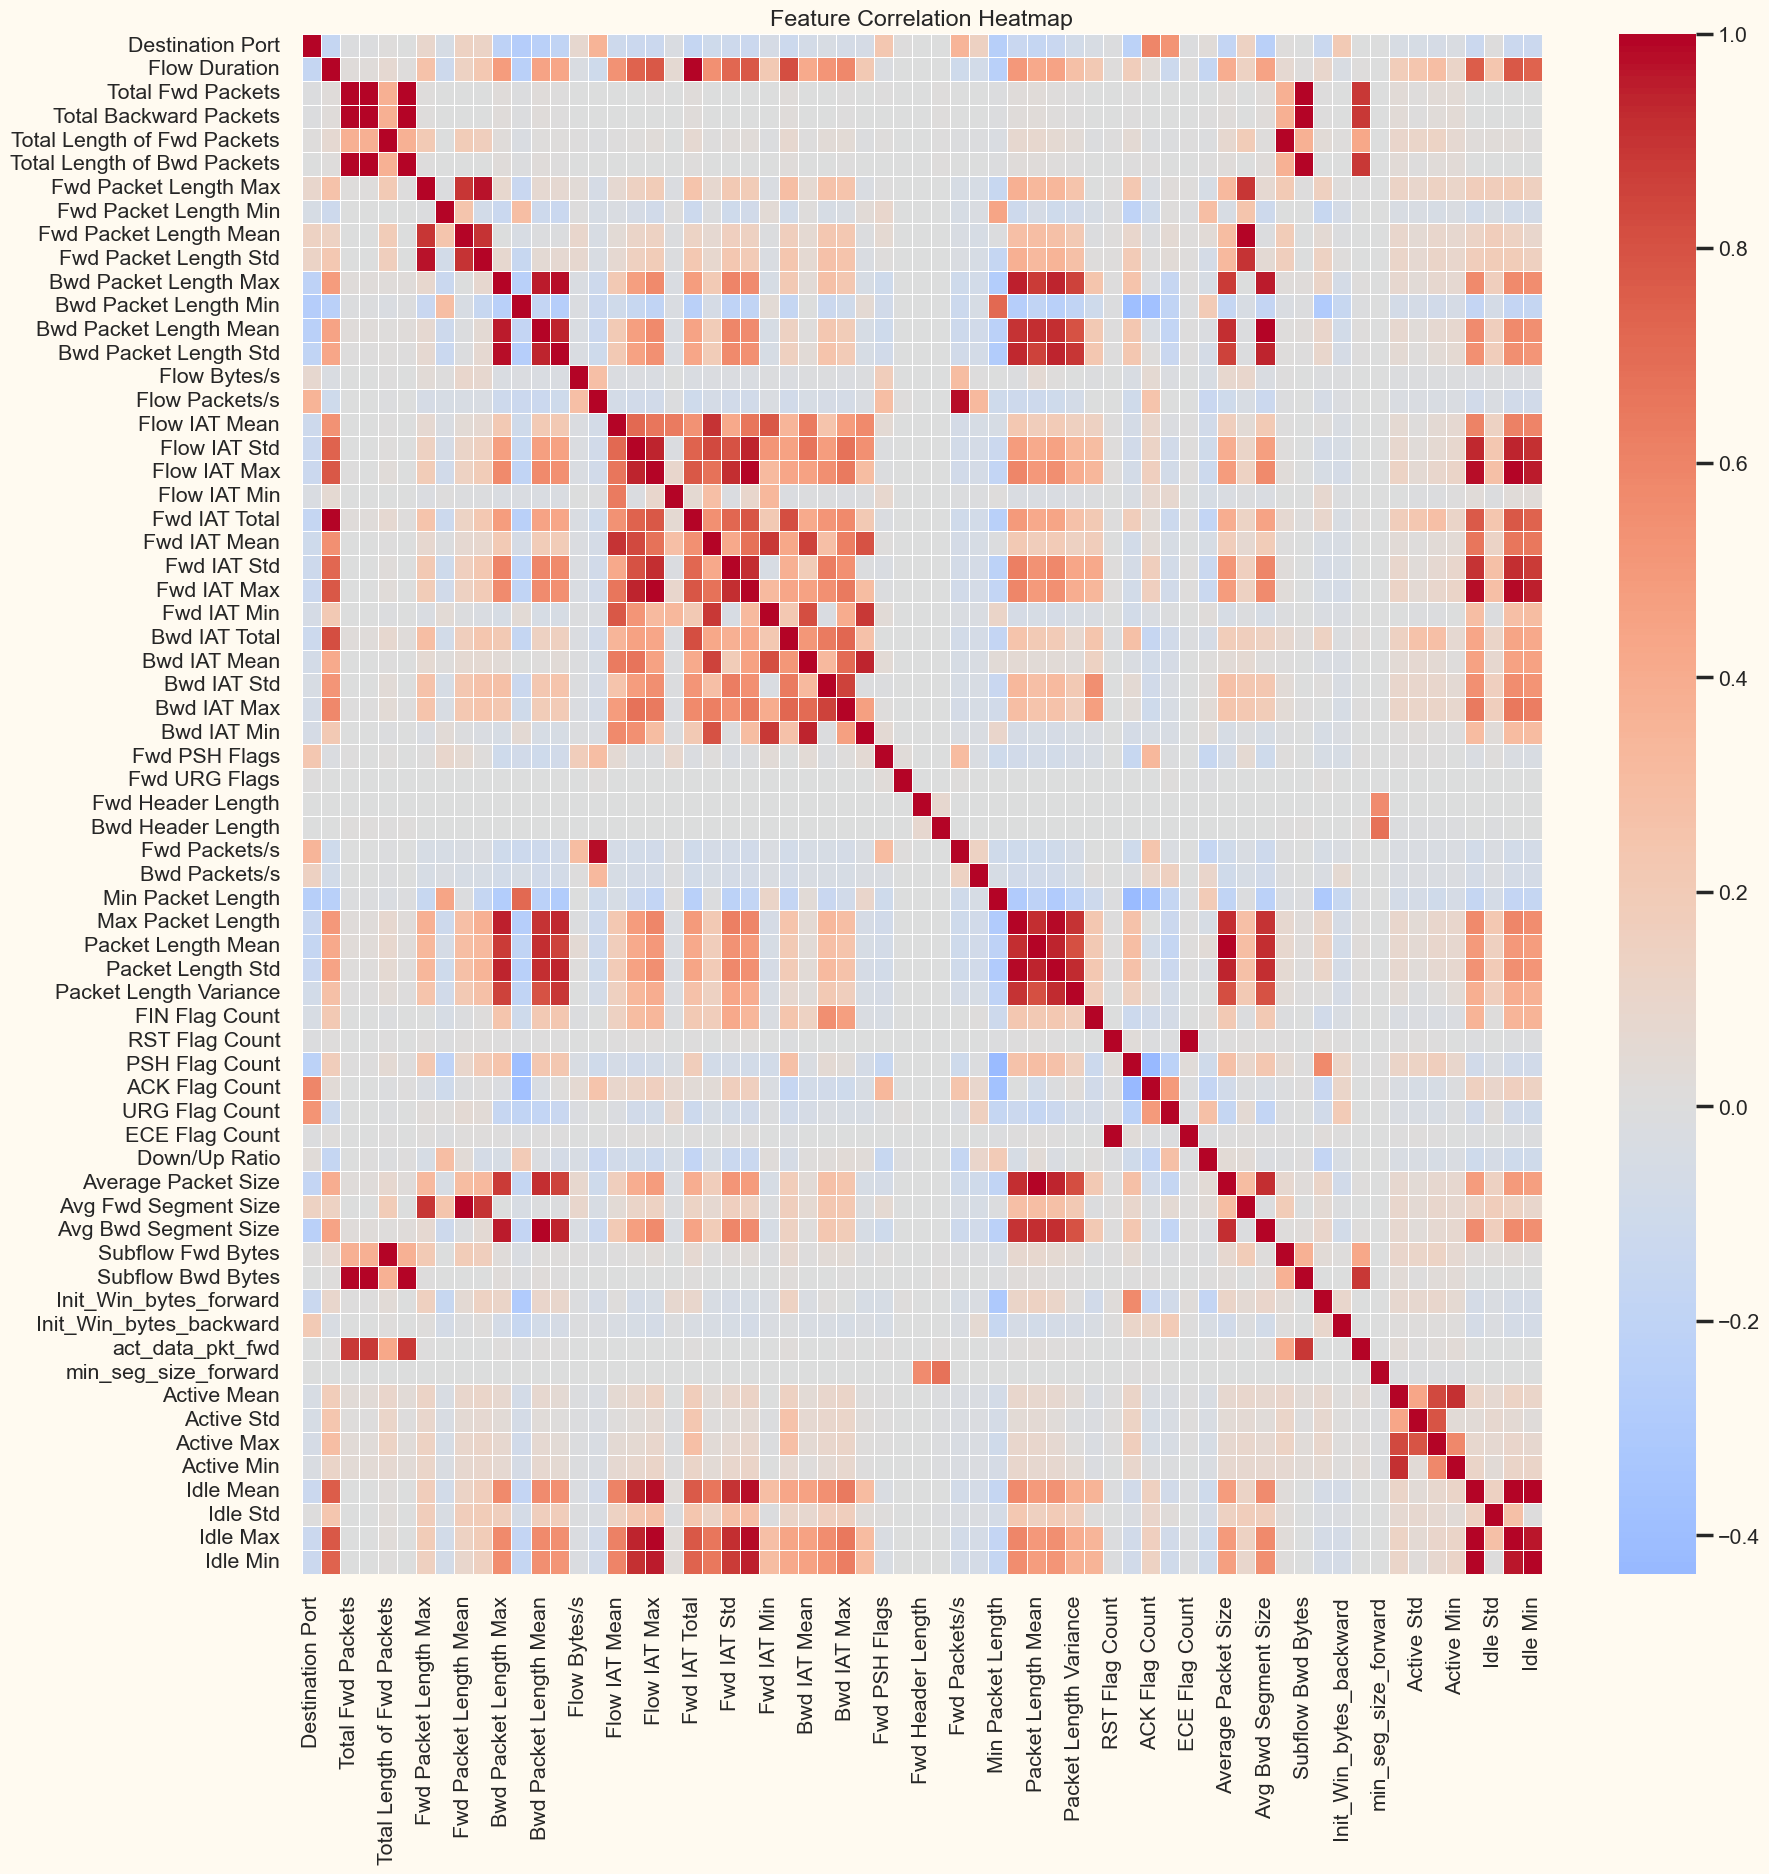

In [32]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(data)
high_corr = correlation_analysis(data, numeric_features)

In [33]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
  print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
  if item[2] >= 0.95:
    high_multicollinearity.append(item)

Flow Duration has a high correlation with Fwd IAT Total: 0.9985
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Total Fwd Packets has a high correlation with Total Length of Bwd Packets: 0.997
Total Fwd Packets has a high correlation with Subflow Bwd Bytes: 0.997
Total Fwd Packets has a high correlation with act_data_pkt_fwd: 0.8874
Total Backward Packets has a high correlation with Total Length of Bwd Packets: 0.9945
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9944
Total Backward Packets has a high correlation with act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with act_data_pkt_fwd: 0.884
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.889
Fwd Packet Length Max has a high correlation with Fwd Packet Length Std: 0.968

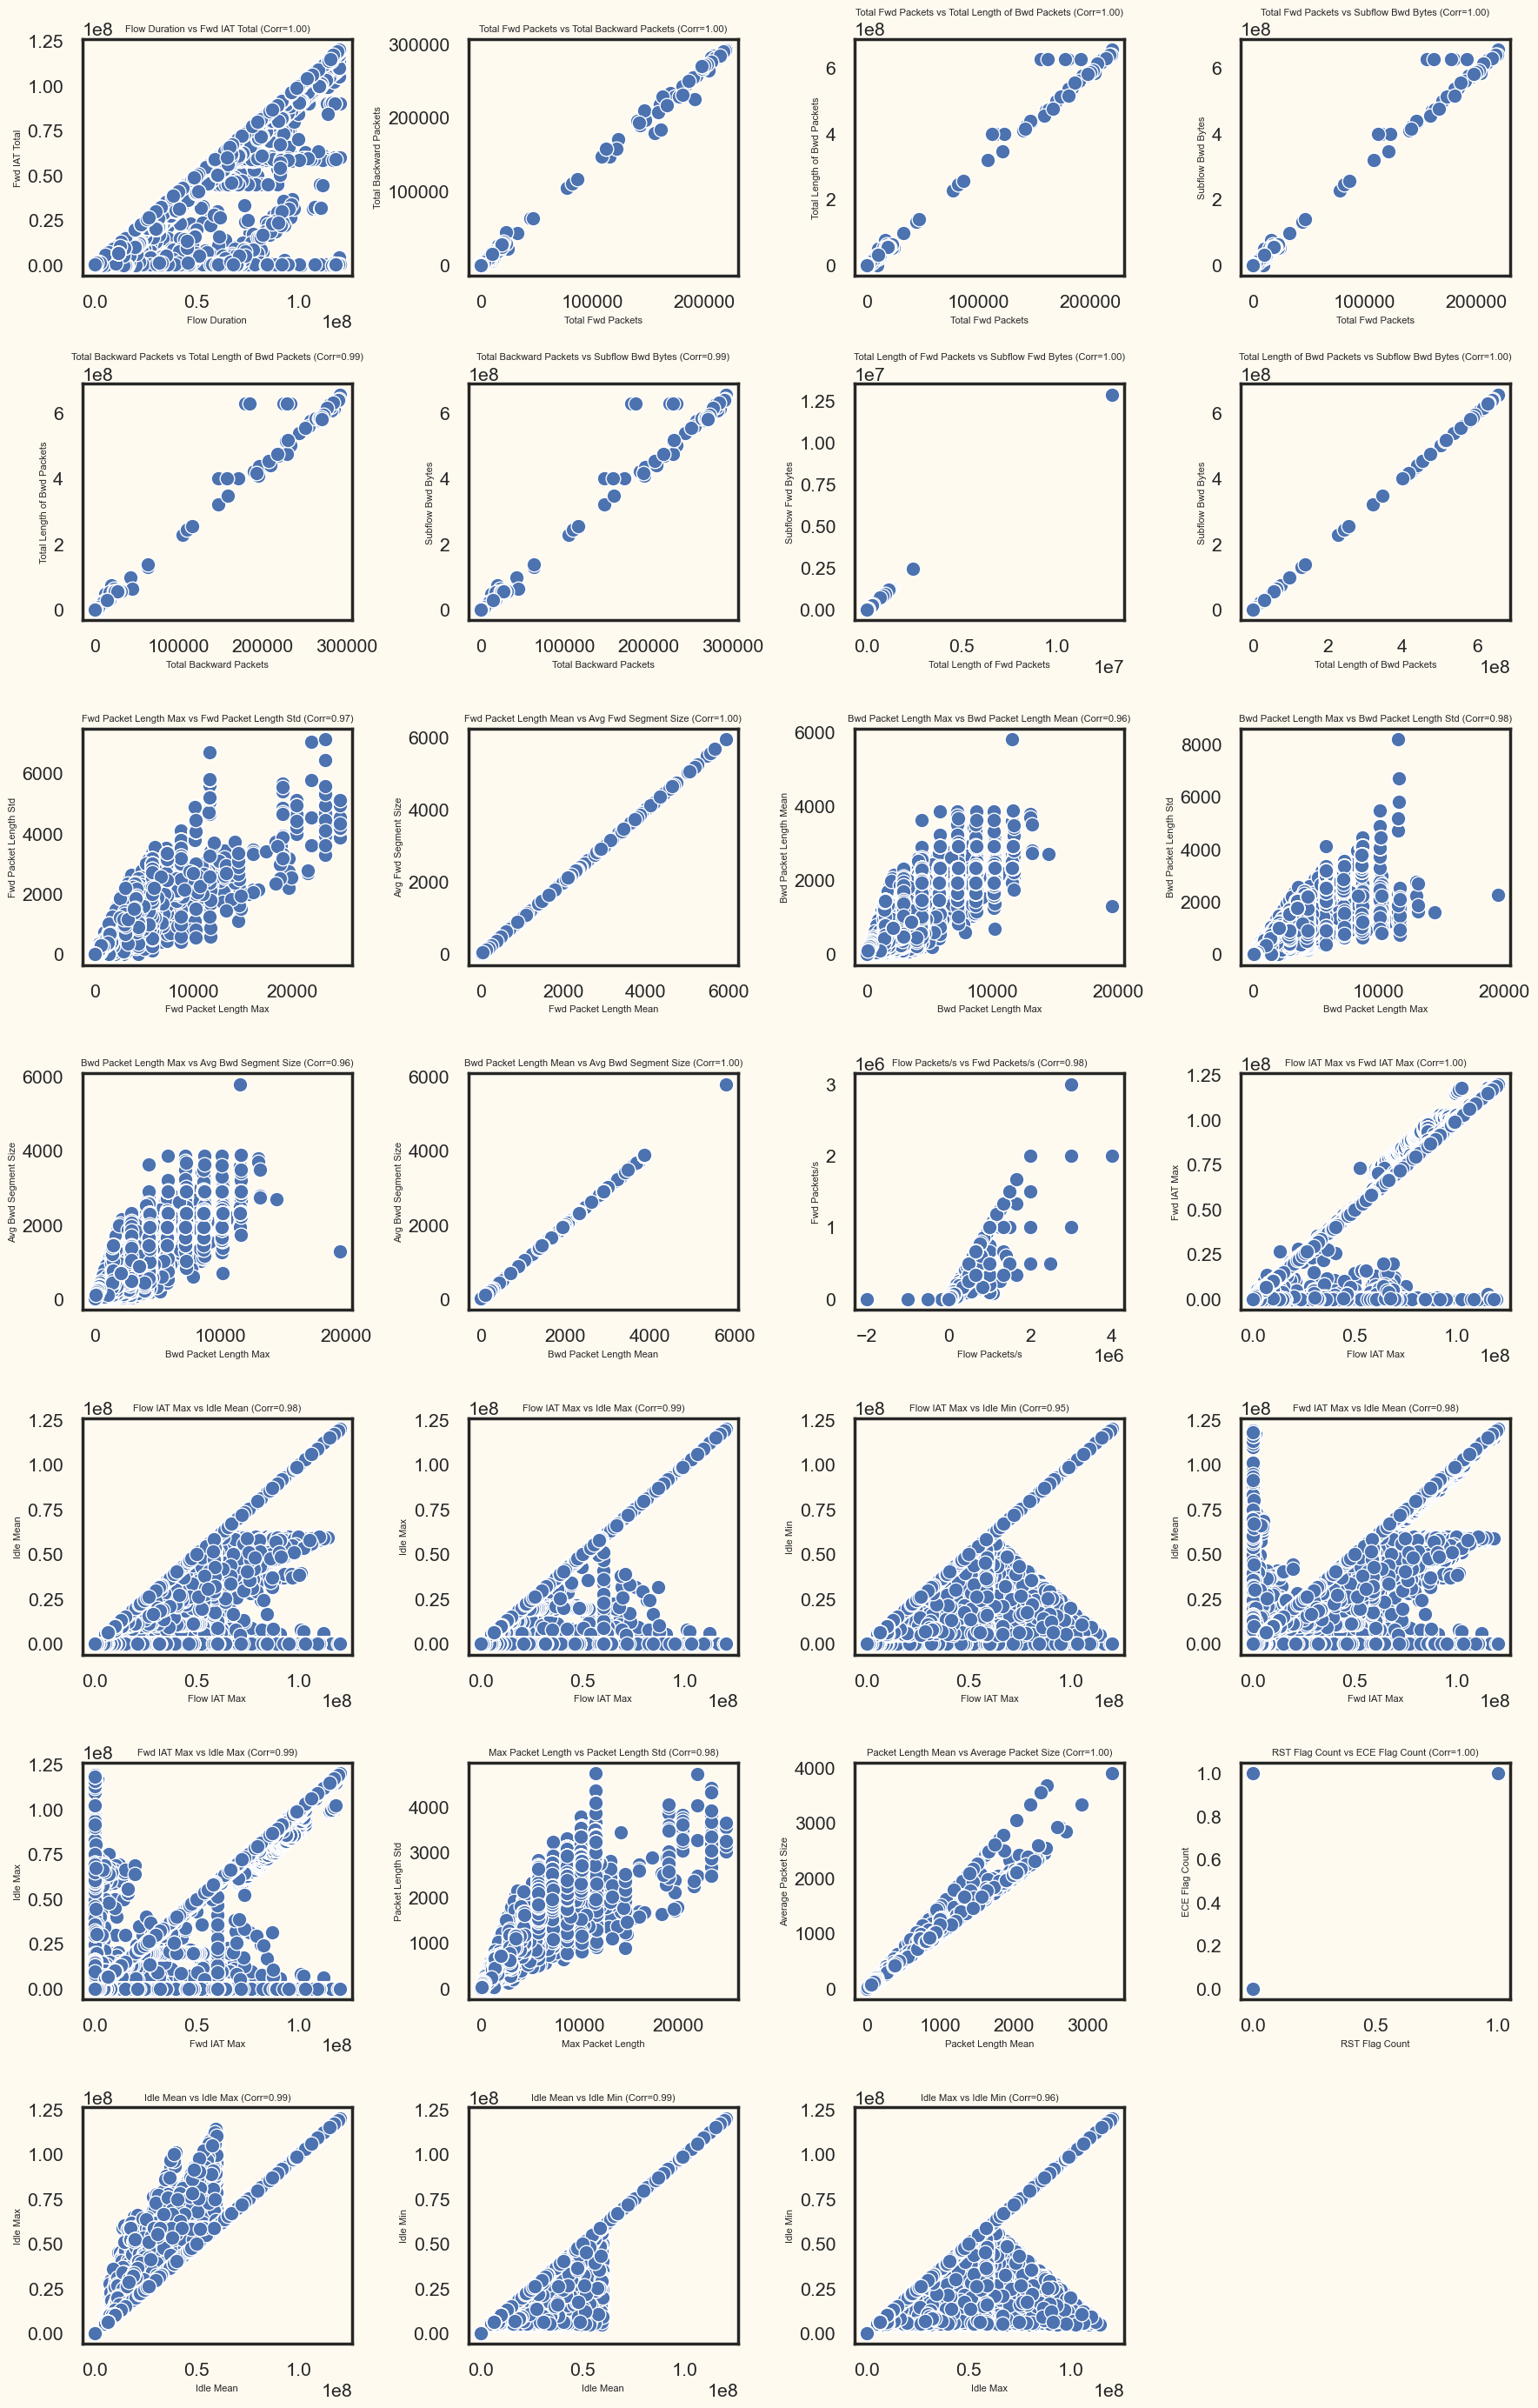

In [34]:
# Plotting the pairs with very high correlation for better visualization

n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
  feature_x = item[0]
  feature_y = item[1]
  corr_value = item[2]

  # Scatter plot
  sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[i])
  axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
  axes[i].set_xlabel(feature_x, fontsize=8)
  axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [35]:
# Removal of columns based on correlation analysis
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
data.drop(columns=selected_columns, inplace=True)

In [36]:
# Updating the variables and checking dataset shape
numeric_features, categorical_features = get_feature_types(data)
data.shape

(2520751, 61)

3.3. Outliers

In [37]:
# Calculation of the percentage of outliers for each feature (df) – IQR -> dict with outliers percentage
def calculate_outliers_percentage(df):

  outlier_percentages = {}  # empty dictionary to store outlier percentages

  for column in df.columns:
    Q1 = df[column].quantile(0.25)  # first quartile (Q1) for the column
    Q3 = df[column].quantile(0.75)  # third quartile (Q3) for the column
    IQR = Q3 - Q1  # Interquartile Range (IQR)

    lower_bound = Q1 - 1.5 * IQR  # lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # upper bound for outliers

    # Identify outliers in the column
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    # Calculate the percentage of outliers for the column
    outlier_percentage = len(outliers) / len(df) * 100
      # Store the outlier percentage in the dictionary
    outlier_percentages[column] = outlier_percentage

  return outlier_percentages

<Figure size 1500x1000 with 0 Axes>

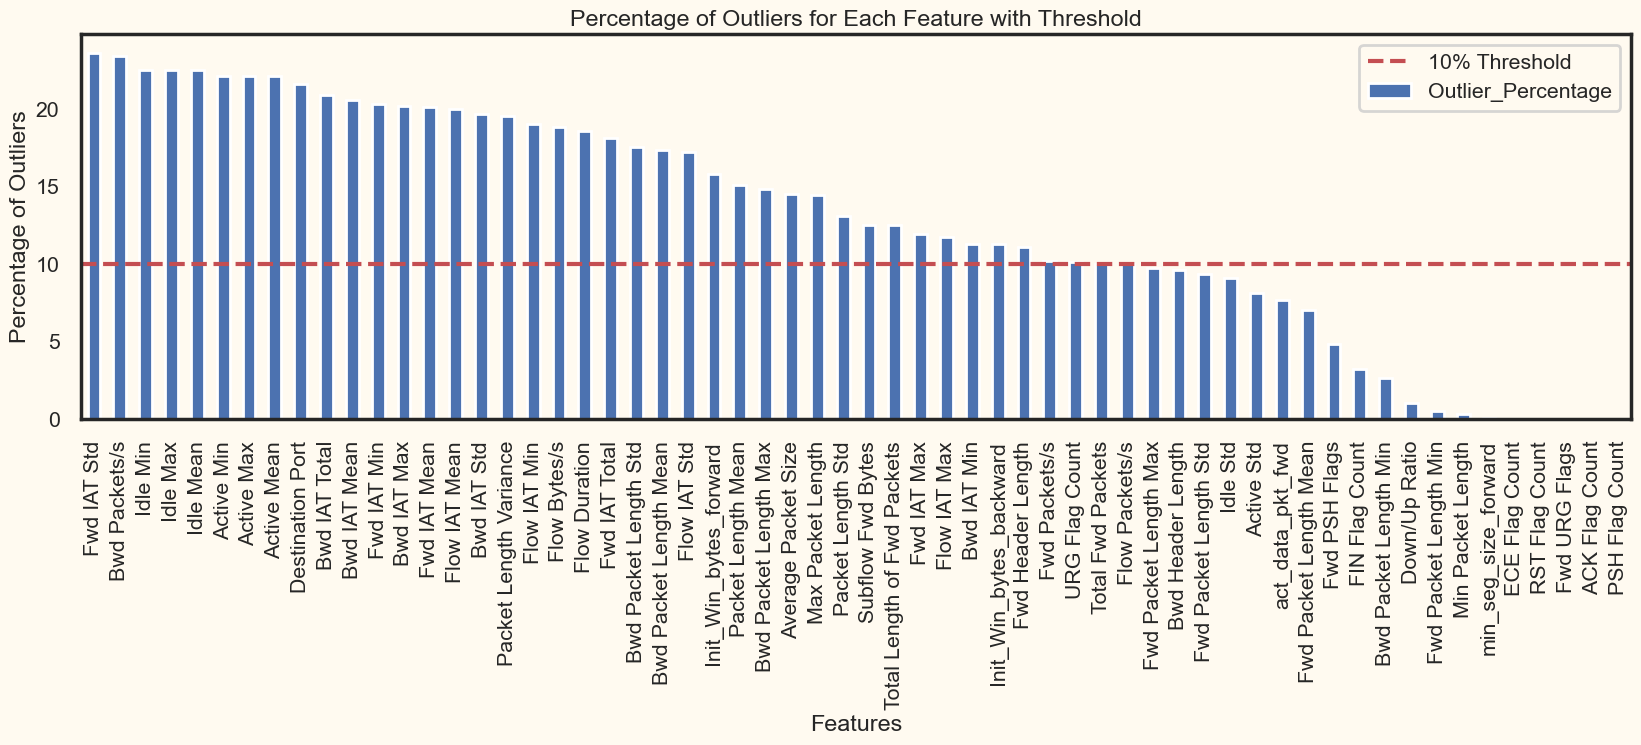

In [38]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(data[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

In [39]:
# Print the features with high outlier percentages
print(f"Features with outlier percentage above {threshold}%:\n")
print(high_outlier_features.sort_values('Outlier_Percentage', ascending=False))

# Cleaning up
del outliers_df

Features with outlier percentage above 10%:

                             Outlier_Percentage
Fwd IAT Std                           23.657989
Bwd Packets/s                         23.402391
Idle Min                              22.501508
Idle Max                              22.501508
Idle Mean                             22.501508
Active Min                            22.167917
Active Max                            22.167917
Active Mean                           22.167917
Destination Port                      21.645137
Bwd IAT Total                         20.926819
Bwd IAT Mean                          20.602908
Fwd IAT Min                           20.366311
Bwd IAT Max                           20.187555
Fwd IAT Mean                          20.126462
Flow IAT Mean                         19.985512
Bwd IAT Std                           19.700319
Packet Length Variance                19.538899
Flow IAT Min                          19.072649
Flow Bytes/s                          18.84

3.4. Class Imbalance

In [40]:
# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = data['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic                2095057       83.11
1             DoS                 193745        7.69
2            DDoS                 128014        5.08
3   Port Scanning                  90694        3.60
4     Brute Force                   9150        0.36
5     Web Attacks                   2143        0.09
6            Bots                   1948        0.08


In [41]:
# Cleaning up
del attack_counts_df

In [42]:
# Removing statiscally irrelavant features from the dataset
cols_to_remove = ['ECE Flag Count', 'RST Flag Count', 'Fwd URG Flags', 'Idle Std', 'Fwd PSH Flags', 'Active Std', 'Down/Up Ratio', 'URG Flag Count']
data.drop(columns=cols_to_remove, inplace=True)

In [43]:
data.shape

(2520751, 53)

In [44]:
# --- Encode attack labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Attack Type'])

# Save the mapping for later (to decode predictions)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Attack Type → Encoded):")
print(label_mapping)

Label Mapping (Attack Type → Encoded):
{'Bots': 0, 'Brute Force': 1, 'DDoS': 2, 'DoS': 3, 'Normal Traffic': 4, 'Port Scanning': 5, 'Web Attacks': 6}


In [45]:
# Split with encoded labels
X = data.drop('Attack Type', axis=1)
y = y_encoded

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set using the fitted scaler
X_test_scaled = scaler.transform(X_test)

In [47]:
X_train_scaled.shape

(1764525, 52)

In [49]:
# Path to save
DATA_DIR = Path("E:/ZeusOps/data/CIC-IDS-2017/processed")
DATA_DIR.mkdir(parents=True, exist_ok=True)  # create folder if not exists

# Convert NumPy arrays to DataFrames before saving
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_df.to_pickle(DATA_DIR / "cicids_x_train.pkl")
X_test_df.to_pickle(DATA_DIR / "cicids_x_test.pkl")

# Save y directly (already DataFrame)
pd.Series(y_train).to_pickle(DATA_DIR / "cicids_y_train.pkl")
pd.Series(y_test).to_pickle(DATA_DIR / "cicids_y_test.pkl")

# scaler for future 
joblib.dump(scaler, DATA_DIR / "cicids_scaler.pkl")

# Save encoder + mapping
joblib.dump(label_encoder, DATA_DIR / "cicids_label_encoder.pkl")

print("✅ Train/Test datasets saved successfully!")

✅ Train/Test datasets saved successfully!
